In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
#os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [4]:
key = jax.random.PRNGKey(0)

In [5]:
import mrfx
from mrfx.models import GMRF, GUM
from mrfx.samplers import SpectralSamplerGMRF, FFTSamplerGMRF, GUMSampler

## Timing experiments

Given a $\kappa$ we empirically look for the corresponding $\beta$ in a Pott's model, in terms of global appearance of the simulated field.

In [6]:
kappa = 0.1

We need to find what is the equivalent $\beta$ for this $\kappa$. We do it experimentally. Let us simulate many discretized GUMs for the fixed $\kappa$ and average the estimated $\beta$ over them:

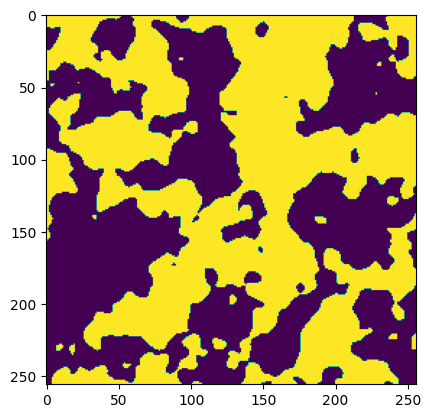

In [7]:
gum = GUM(kappa=kappa, K=2, dim=2)
gum_sampler = GUMSampler(n_bands=2500, lx=256, ly=256, method="spectral")
key, subkey = jax.random.split(key, 2)
gum_x = gum_sampler.sample_image(gum, subkey)[0]
plt.imshow(gum_x)
plt.show()

In [8]:
# from mrfx.samplers._utils import get_neigh

# neigh_size = 1
# def est_alpha(Xt):
#     K = jnp.unique(Xt).shape[0] 
#     P,Q = Xt.shape
#     t=0
#     def get_local_sum(Xt, u, v, Q, P):
#         neigh = get_neigh(Xt, u, v, Q, P, neigh_size)
#         return jnp.sum(neigh == Xt[u, v])
#     v_get_local_sum = jax.vmap(
#         jax.vmap(
#             get_local_sum, (None, 0, None, None, None)
#         ), (None, None, 0, None, None)
#     )
#     t = jnp.sum(v_get_local_sum(Xt, jnp.arange(Q), jnp.arange(P), Q, P))
   
#     freq=t/((2 * neigh_size + 1) ** 2 *(P)*(Q))
#     alpha=(K**2/(2*(K-1)))*(freq-(1/K))
#     return alpha

# alphas = []

# for Xt in gums_x:
#     alphas.append(est_alpha(Xt))

# alpha = jnp.mean(jnp.asarray(alphas))
# print(alpha)

Stopping Gibbs sampler, cause: Convergence criterion is reached


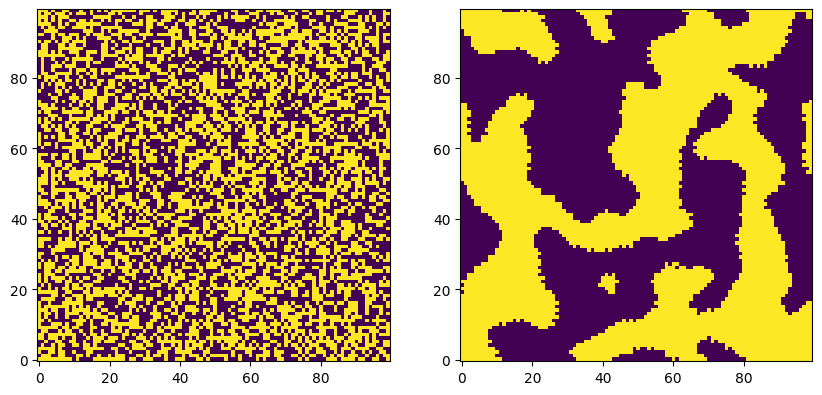

In [9]:
from mrfx.models import Potts
K = 2
beta = 2
potts_model = Potts(K, beta, neigh_size=1)
from mrfx.samplers import GibbsSampler, ChromaticGibbsSampler
key, subkey = jax.random.split(key, 2)

# Note that it is OK that Gibbs do not converge for low beta values
# gibbs = GibbsSampler(256, 256, eps=0.05, max_iter=2000)
# X_init, X_list, n_iter = gibbs.run(potts_model, subkey)
chro_gibbs2 = ChromaticGibbsSampler(100, 100, eps=0.05, max_iter=10000, color_update_type="vmap_in_color")
X_init, X_list, n_iter = chro_gibbs2.run(potts_model, subkey)
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(X_init, origin="lower")
axes[1].imshow(X_list[-1], origin="lower")
plt.show()

In [10]:
import numpy as np
import pandas as pd
import time
def time_update_one_image(
    Sampler,
    Model,
    key,
    Ks,
    sizes,
    reps,
    kwargs_sampler=None,
    kwargs_model=None,
    exp_name=None,
    return_X=False
) -> list:
    """
    Get a time estimate of the call to `update_one_image` for a given sampler
    and a given model

    Parameters
    ----------
    Sampler
        A non-instantiated AbstractGibbsSampler
    Model
        A non-instantiated AbstractMarkovRandomFieldModel
    key
        A jax PRNG key
    Ks
        A list, sequence, numpy array of the numbers of classes of the model
        that we want to time
    size
        An list, sequence, array of pairs of each (lx, ly), ie. the dimensions
        over which we want to time the sampler
    reps
        An integer. The number of time sample we average for a given
        combination of K and size
    kwargs_sampler
        A dictionary with the remaining arguments needed to instanciate the
        sampler (passed as keywords arguments): all the arguments apart from
        `lx` and `ly`
    kwargs_model
        A dictionary with the remaining arguments needed to instanciate the
        model (passed as keywords arguments): all the arguments apart from
        `K`

    Note that Ks must be a numpy array (because it is passed as a static_argnum
    in the jitted functions of mrfx and jax.numpy arrays are non hashable)
    """
    Ks = np.asarray(Ks)
    times = []
    if return_X:
        samples = []
    else:
        samples = None
        
    for k in Ks:
        times.append([])
        model = Model(K=k, **kwargs_model)
        if return_X:
            samples.append([])
        for lx, ly in sizes:
            sampler = Sampler(lx=lx, ly=ly, **kwargs_sampler)

            rep_times = []
            print(f"Rep ( / {reps}), ", end="")
            key, subkey = jax.random.split(key, 2)

            # compilation
            start = time.time()
            j_sample_image = jax.jit(sampler.sample_image)
            X, _ = j_sample_image(model=model, key=key)
            X.block_until_ready()
            end = time.time()
            compilation_time = end - start

            if return_X:
                samples[-1].append([])
            for r in range(reps):
                key, subkey = jax.random.split(key, 2)

                start = time.time()
                X, _ = j_sample_image(model=model, key=key)
                X.block_until_ready()
                end = time.time()
                runtime = end - start

                rep_times.append(runtime)
                if return_X:
                    samples[-1][-1].append(X)
                print(f"{r+1} ", end="")
            runtime_mean = np.mean(rep_times)
            print(f"\n{k=}, {lx=}, {ly=}, {compilation_time=}, {runtime_mean=}")

            times[-1].append(runtime_mean)
    if exp_name is not None:
        df = pd.DataFrame(
             {"size":[lx*ly for lx, ly in sizes]} |
            {Ks[i]:times[i] for i in range(len(Ks))}
        )
        df.to_csv(f"{exp_name}.csv", index=False)
    return times, samples

In [9]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 4) #8)
sizes = [(2 ** e, 2 ** e) for e in range(4, 6)]#10)]
times = time_update_one_image(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=100,
    kwargs_sampler={"method":"fourier"},
    kwargs_model={"kappa":kappa, "dim":2},
    exp_name='GUMSampler_fourier_GPU'
) 

/tmp/ipykernel_26422/273311803.py:58: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


Rep ( / 100), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=2, lx=16, ly=16, compilation_time=0.650010347366333, runtime_mean=0.012311999797821044
Rep ( / 100), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
k=2, lx=32, ly=32, compilation_time=0.5711579322814941, runtime_mean=0.012726740837097168
Rep ( / 100), 

KeyboardInterrupt: 

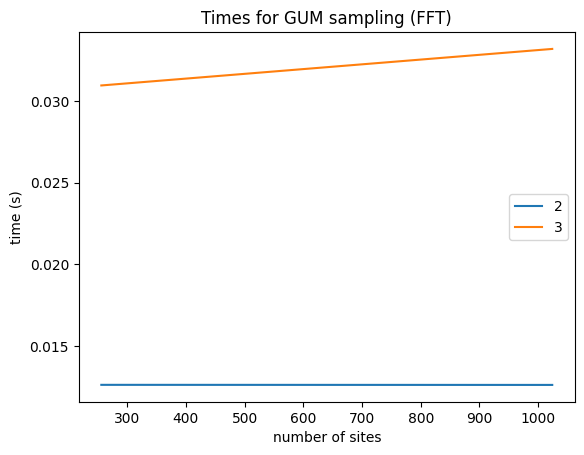

In [15]:
from mrfx.experiments import plot_benchmark
plot_benchmark(Ks, sizes, times, title="Times for GUM sampling (FFT)")

In [15]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 8)
sizes = [(2 ** e, 2 ** e) for e in range(4, 10)]
times = time_update_one_image(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=100,
    kwargs_sampler={"n_bands":2500, "method":"spectral"},
    kwargs_model={"kappa":0.05, "dim":2},
) 

/tmp/ipykernel_8965/4262026348.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


Rep ( / 250), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 
k=2, lx=16, ly=16, compilation_time=1.8248364925384521, runtime_mean=0.0005338811874389649
Re

In [10]:
from mrfx.experiments import plot_benchmark
plot_benchmark(Ks, sizes, times, title="Times for GUM sampling (spectral)")

NameError: name 'times' is not defined

## Compute statistics 

In [64]:
def compute_stats(samples):
    for k in range(len(samples)):
        p_x_0 = 0
        for X in samples[k][0]:
            p_x_0 += (X == 0).mean()
        p_x_0 /= len(samples[k][0])
        std_p_x_0 = 0
        for X in samples[k][0]:
            std_p_x_0 += (p_x_0 - (X == 0).mean()) ** 2
        std_p_x_0 /= len(samples[k][0])
        std_p_x_0 = np.sqrt(std_p_x_0)
        print(Ks[k], p_x_0, std_p_x_0)

In [65]:
kappa = 0.1

In [66]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 6)
sizes = [(100, 100)]
times, samples_gum_fourier = time_update_one_image(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=50,
    kwargs_sampler={"method":"fourier"},
    kwargs_model={"kappa":kappa, "dim":2},
    exp_name='GUMSampler_fourier_GPU',
    return_X=True
) 

/tmp/ipykernel_28807/273311803.py:58: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=2, lx=100, ly=100, compilation_time=0.7454283237457275, runtime_mean=0.019728326797485353
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=3, lx=100, ly=100, compilation_time=1.2444167137145996, runtime_mean=0.03169302463531494
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=4, lx=100, ly=100, compilation_time=1.407860517501831, runtime_mean=0.04151172161102295
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=5, lx=100, ly=100, compilation_time=2.700543165206909, runtime_mean=0.10217535018920898


In [67]:
compute_stats(samples_gum_fourier)

2 0.48923206 0.12904526
3 0.36017597 0.12763683
4 0.237436 0.111200094
5 0.21574199 0.098903745


In [69]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 6)
sizes = [(100, 100)]
times, samples_gum_spectral = time_update_one_image(
    Sampler=GUMSampler,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=50,
    kwargs_sampler={"method":"spectral", "n_bands":2500},
    kwargs_model={"kappa":kappa, "dim":2},
    exp_name='GUMSampler_fourier_GPU',
    return_X=True
) 

/tmp/ipykernel_28807/273311803.py:58: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)


Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=2, lx=100, ly=100, compilation_time=1.809288501739502, runtime_mean=0.0026019859313964845
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=3, lx=100, ly=100, compilation_time=2.3659064769744873, runtime_mean=0.0059208345413208005
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=4, lx=100, ly=100, compilation_time=5.5161731243133545, runtime_mean=0.009020872116088867
Rep ( / 50), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
k=5, lx=100, ly=100, compilation_time=7.038554906845093, runtime_mean=0.010016288757324219


In [70]:
compute_stats(samples_gum_spectral)

2 0.50781196 0.13948289
3 0.34444797 0.10047755
4 0.24328595 0.09532923
5 0.20718199 0.10286702


In [83]:
from functools import partial
from mrfx.samplers._utils import euclidean_dist, euclidean_dist_torus

@partial(jax.jit, static_argnames=['lx', 'ly', 'distance_function'])
def get_neigh_at_d(xy, d, X, lx, ly, distance_function):
    """
    from a pixel (x,y) get the values of all the neighbors at distance d
    """
    neigh = jnp.empty((lx, ly))
    ind = jnp.dstack(
            jnp.meshgrid(jnp.arange(lx), jnp.arange(ly))
    ).reshape((-1, 2))
    v_eval = jax.vmap(lambda all_x_y: distance_function(
        x1=xy[0], x2=all_x_y[0], y1=xy[1], y2=all_x_y[1], lx=lx, ly=ly)
    )
    dists = v_eval(ind).squeeze()
    return jnp.where(jnp.logical_and(dists <= d + 0.1, dists >= d - 0.1),
                         X.flatten(),
                         jnp.nan)


def compute_proba_with_d(samples, lx, ly, exp_name=None):
    distances = jnp.arange(0,  50)
    
    ind = jnp.dstack(
            jnp.meshgrid(jnp.arange(lx), jnp.arange(ly))
    ).reshape((-1, 2))

    avg_on_samples = jnp.zeros(distances.shape)
    reps = 5
    for i in range(reps):
        def compute_proba_at_d(carry, d):#, X, lx, ly):
            X, = carry
            def compute_proba_at_d_one_site(xy, d):
                neigh_at_d = get_neigh_at_d(xy, d, X, lx, ly, euclidean_dist)
                idx_neigh_at_d = jnp.nonzero(~jnp.isnan(neigh_at_d), size=lx*ly, fill_value=jnp.nan)
                return (jnp.sum(
                    jnp.logical_and(neigh_at_d == X[xy[1], xy[0]], # careful with indexing here!
                                   ~jnp.isnan(neigh_at_d))) /
                        jnp.sum(~jnp.isnan(neigh_at_d)))
            
            v_compute_proba_at_d_one_site = jax.vmap(compute_proba_at_d_one_site, (0, None))
            res = v_compute_proba_at_d_one_site(ind, d)
            return (X,), jnp.mean(res)

        #scan because we must handle d sequentially otherwise RAM explodes
        _, probas_at_d = jax.lax.scan(compute_proba_at_d, (samples[0][0][i],), distances)
        avg_on_samples += probas_at_d
    # v_compute_proba_at_d = jax.vmap(compute_proba_at_d, (0, None, None, None))
    # return v_compute_proba_at_d(distances, samples[0][0][0], 100, 100)
    print(avg_on_samples / reps)
    if exp_name is not None:
        df = pd.DataFrame(
                 {"d":distances} |
                {"proba_equal_at_d":avg_on_samples / reps}
            )
        df.to_csv(f"{exp_name}.csv", index=False)
    return avg_on_samples / reps

In [73]:
with jax.default_device(jax.devices("cpu")[0]):
    probas_with_d_gum_fourier = compute_proba_with_d(samples_gum_fourier, 100, 100, 'proba_with_d_GUM_Fourier')
    probas_with_d_gum_spectral = compute_proba_with_d(samples_gum_spectral, 100, 100, 'proba_with_d_GUM_Spectral')

[1.         0.9383051  0.89363587 0.8553275  0.8208175  0.7882609
 0.7597937  0.73457813 0.71197414 0.69255054 0.6735411  0.6569521
 0.6421577  0.62949145 0.6182539  0.6073553  0.5968907  0.58874667
 0.5800518  0.5715426  0.5649161  0.55821675 0.55417526 0.5453397
 0.54058844 0.53615916 0.5309745  0.52878666 0.5190943  0.5204813
 0.5155891  0.509138   0.50853056 0.5024716  0.5067002  0.50146407
 0.50003767 0.49679548 0.49974245 0.5013455  0.49896103 0.5003689
 0.4996128  0.50035834 0.50160944 0.50094396 0.50267607 0.50145537
 0.5017678  0.501401  ]
[1.         0.9654542  0.9314359  0.89860666 0.8673817  0.8378776
 0.81017303 0.78597146 0.76386917 0.7444899  0.7255619  0.70744574
 0.6923414  0.678073   0.66463804 0.6522747  0.6396414  0.6308124
 0.62052745 0.61099803 0.6032338  0.5956937  0.5895568  0.5819241
 0.5755934  0.5703678  0.5650533  0.5602213  0.55550545 0.5519113
 0.54656893 0.5433325  0.5410272  0.5394422  0.53604984 0.5328369
 0.53054726 0.5289501  0.5239499  0.5228116  0.5

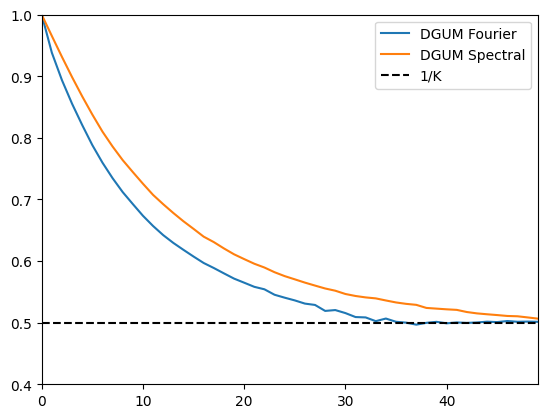

In [80]:
import jax
key = jax.random.PRNGKey(0)
import numpy as np
from mrfx.experiments import time_complete_sampling, plot_benchmark
from mrfx.samplers import GibbsSampler, ChromaticGibbsSampler
from mrfx.models import Potts
K = 2
beta = 1.
potts_model = Potts(K, beta, neigh_size=1)

Ks = np.arange(2, 3)
sizes = [(100, 100)]#(2 ** e, 2 ** e) for e in range(8, 10)]
reps = 5

key, subkey = jax.random.split(key, 2)
times, n_iterations, samples = time_complete_sampling(ChromaticGibbsSampler, Potts, subkey, Ks, sizes, reps,
                                             kwargs_sampler={"eps":0.05, "max_iter":10000, "color_update_type":"vmap_in_color"},
                                             kwargs_model={"beta":1.}, return_X=True)

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/experiments/_benchmark.py:166: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(k, **kwargs_model)


Rep ( / 5): Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
1 Stopping Gibbs sampler, cause: Convergence criterion is reached
2 Stopping Gibbs sampler, cause: Convergence criterion is reached
3 Stopping Gibbs sampler, cause: Convergence criterion is reached
4 Stopping Gibbs sampler, cause: Convergence criterion is reached
5 
k=2, lx=100, ly=100, compilation_time=2.3208940029144287, runtime_mean=2.3592066764831543, n_iter_mean=29.0


In [84]:
with jax.default_device(jax.devices("cpu")[0]):
    probas_with_d_mrf_gibbs = compute_proba_with_d(samples, 100, 100, 'proba_with_d_GUM_Fourier')

[1.         0.93225    0.8848284  0.8313983  0.7804017  0.73012936
 0.68246335 0.6415553  0.6054188  0.5757346  0.5510129  0.52789724
 0.5183057  0.50816095 0.49978572 0.49819502 0.4925855  0.4989769
 0.49809918 0.4972753  0.49998108 0.50309306 0.5041246  0.50664794
 0.50554    0.51039714 0.51233876 0.5087534  0.50947857 0.5062244
 0.51178575 0.5116056  0.5086888  0.50607264 0.5052299  0.5044962
 0.50036013 0.4978765  0.5002772  0.49779367 0.4951128  0.4918305
 0.49472094 0.49758977 0.49400753 0.49159545 0.4944291  0.49414816
 0.49394783 0.4944461 ]


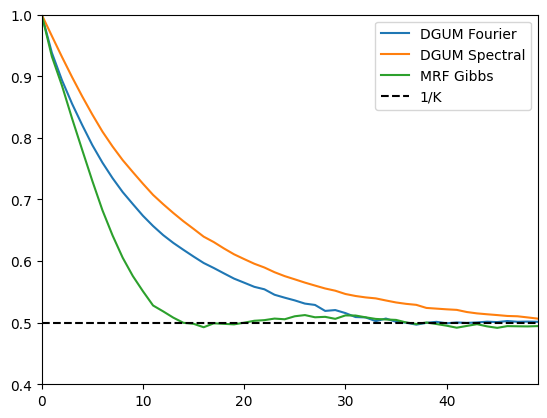

In [86]:
plt.rcParams.update({'font.size': 10})
distances = jnp.arange(0,  50)
title = 'Empirical $p(x_i = x_j | \| i-j \| = d)$'
plt.ylim(1/K-0.1,1)
plt.xlim(distances[0],distances[-1])
plt.plot(distances, probas_with_d_gum_fourier,label='DGUM Fourier')
plt.plot(distances, probas_with_d_gum_spectral,label='DGUM Spectral')
plt.plot(distances, probas_with_d_mrf_gibbs,label='MRF Gibbs')

plt.plot(distances,np.ones_like(distances)/2,'--k',label='1/K')
plt.legend()
plt.savefig(f"{title}.pdf")